# sustainability_topic_modeling

In [1]:
#Load in nlp pipeline

#import sustainability_nlp_pipeline
from sustainability_nlp_pipeline import nlp_pipeline as nlp_func
from sustainability_nlp_pipeline import cleaned_text

In [219]:
#Load in other packages

import re
import pandas as pd
import pickle
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF, TruncatedSVD

In [3]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
#Connect to MongoDB

from pymongo import MongoClient
client = MongoClient()
db = client.environment
sustainability_collection = db.sustainability

Create Regex Pattern Specific to Twitter Language:

In [5]:
'''

Tweet Tokenizer Adapted from :  https://github.com/adonoho/TweetTokenizers/blob/master/PottsTweetTokenizer.py
   
This Tokenizer preserves Twitter language including:  usernames, hashtags, symbols html, etc.

'''

regex_code = (

    r"""(?:<[^>]+>)""",                             # HTML tags
    r"""(?:http[s]?://t.co/[a-zA-Z0-9]+)""",        # URLs 
    r"""(?:http[s]\S+?)""",                         # URLs
    r"""(?:@[\w_]+)""",                             # Twitter username
    r"""(?:\#+[\w_]+[\w\'_\-]*[\w_]+)""",           # Twitter hashtags
    r"""(?:\$[a-zA-Z]{1,6}([._][a-zA-Z]{1,2})?)""", # Twitter symbols / cashtags
    r"""(?:[a-z][a-z'\-_]+[a-z])""",                # Words with apostrophes or dashes
    r"""(?:[+\-]?\d+[,/.:-]\d+[+\-]?)""",           # Numbers, including fractions, decimals
    r"""(?:[\w_]+)""",                              # Words without apostrophes or dashes
    r"""(?:\.(?:\s*\.){1,})"""                      # Ellipsis
    )

#regex_text = re.sub(r'[%s]'% (regex_pattern), ' ')

regex_pattern = re.compile(r"""(%s)"""%"|".join(regex_code), re.VERBOSE | re.I | re.UNICODE)

In [6]:
print(regex_pattern.pattern)

((?:<[^>]+>)|(?:http[s]?://t.co/[a-zA-Z0-9]+)|(?:http[s]\S+?)|(?:@[\w_]+)|(?:\#+[\w_]+[\w\'_\-]*[\w_]+)|(?:\$[a-zA-Z]{1,6}([._][a-zA-Z]{1,2})?)|(?:[a-z][a-z'\-_]+[a-z])|(?:[+\-]?\d+[,/.:-]\d+[+\-]?)|(?:[\w_]+)|(?:\.(?:\s*\.){1,}))


In [7]:
regex_tokenizer = RegexpTokenizer(pattern=regex_pattern.pattern,gaps=True, discard_empty = True)

Define Stop Words:

In [85]:
stop_words = stopwords.words('english')

#Add additional stop words in here:

additional_stop_words = ['RT', 'rt', "’", "sustainability", "sustainable", "sustainabl", "sustain"]

total_stop_words = stop_words + additional_stop_words

In [86]:
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [87]:
print(total_stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [88]:
'be' not in total_stop_words

False

In [89]:
english_cursor = sustainability_collection.aggregate([{'$match': {'lang': 'en'}},{'$sample':{'size':5}}])

In [90]:
for tweet in english_cursor:
    print (tweet['text'])

RT @hbsislamabad: @GERinPAK4youth Marion Pfennings took part in @hbsislamabad and @isl_green's plantation drive this weekend and showed tha…
.@SmithfieldFoods combines three supply chains into one, increasing operating efficiency and reducing costs while c… https://t.co/Nq6J7acZcM
What is causing Florida's algae crisis? https://t.co/GxCvxaffRW #sustainability two large scale algae outbreaks in… https://t.co/ywJSbVSbrl
We're #hiring! Click to apply: Pacific Northwest and Canada Division Director - 46698 - https://t.co/XgBKgpVTbJ… https://t.co/AQSPeokv0B
Next cohort of Level 1 #onlinecourse starts Sept 24-Nov 11 with @laurence_myers! Learn easy-to-use yet transformati… https://t.co/e0EkyudWAj


**Define Parameters to use in NLP Function**

In [91]:
#TF-IDF

nlp_tfidf = nlp_func(vectorizer=TfidfVectorizer(min_df=0, max_df=0.5, stop_words = total_stop_words), cleaning_function=cleaned_text, tokenizer=TreebankWordTokenizer().tokenize, stemmer=PorterStemmer())

In [92]:
english_cursor = sustainability_collection.aggregate([{'$match': {'lang': 'en'}}])#{'$sample':{'size':5}}
generate_text = (x['text'] for x in english_cursor)
nlp_tfidf.fit_vectorizer(generate_text)

In [93]:
english_cursor = sustainability_collection.aggregate([{'$match': {'lang': 'en'}}])#{'$sample':{'size':5}}
generate_text = (x['text'] for x in english_cursor)
tfidf_tweet = nlp_tfidf.transform_vectorizer(generate_text)
#tfidf_tweet.toarray()

In [94]:
nlp_tfidf.vectorizer.get_feature_names()

['000',
 '01',
 '01156',
 '02',
 '0262226',
 '026222621',
 '03',
 '038',
 '04',
 '05',
 '06',
 '07',
 '08',
 '081218',
 '09',
 '0doubt',
 '10',
 '100',
 '1000',
 '10000',
 '100000',
 '100120',
 '100acceler',
 '100crore',
 '100energytip',
 '101',
 '1010',
 '1018',
 '102',
 '1050',
 '10m',
 '10min',
 '10th',
 '10year',
 '11',
 '110',
 '110k',
 '11am',
 '11minimicroaccuracycompet',
 '12',
 '1200',
 '121',
 '121230',
 '122',
 '12k',
 '12pm',
 '12th',
 '12yearold',
 '13',
 '13082018',
 '1317',
 '133',
 '13628',
 '13bn',
 '14',
 '14001',
 '1408',
 '140billion',
 '141',
 '145',
 '14th',
 '14thaugust',
 '15',
 '150',
 '1500',
 '15000',
 '1529',
 '15m',
 '15th',
 '15year',
 '16',
 '16gb',
 '16th',
 '17',
 '17b',
 '17th',
 '18',
 '18000000',
 '18711',
 '18th',
 '19',
 '193',
 '1950',
 '1969',
 '1980',
 '1985',
 '1991',
 '1994',
 '1997',
 '1998',
 '19th',
 '1day',
 '1l',
 '1m',
 '1n',
 '1st',
 '1st3rd',
 '20',
 '200',
 '2000',
 '20000',
 '200000',
 '2000mile',
 '2001',
 '2003',
 '2009',
 '2010',


In [95]:
#Count Vectorizer

nlp_cv = nlp_func(vectorizer=CountVectorizer(max_df=0.5, stop_words = total_stop_words), cleaning_function=cleaned_text, tokenizer=TreebankWordTokenizer().tokenize, stemmer=PorterStemmer())

In [96]:
english_cursor = sustainability_collection.aggregate([{'$match': {'lang': 'en'}}])#{'$sample':{'size':5}}
generate_text = (x['text'] for x in english_cursor)
nlp_cv.fit_vectorizer(generate_text)

In [97]:
english_cursor = sustainability_collection.aggregate([{'$match': {'lang': 'en'}}])#{'$sample':{'size':5}}
generate_text = (x['text'] for x in english_cursor)
cv_tweet = nlp_cv.transform_vectorizer(generate_text)
#cv_tweet.toarray()

In [98]:
nlp_cv.vectorizer.get_feature_names()

['000',
 '01',
 '01156',
 '02',
 '0262226',
 '026222621',
 '03',
 '038',
 '04',
 '05',
 '06',
 '07',
 '08',
 '081218',
 '09',
 '0doubt',
 '10',
 '100',
 '1000',
 '10000',
 '100000',
 '100120',
 '100acceler',
 '100crore',
 '100energytip',
 '101',
 '1010',
 '1018',
 '102',
 '1050',
 '10m',
 '10min',
 '10th',
 '10year',
 '11',
 '110',
 '110k',
 '11am',
 '11minimicroaccuracycompet',
 '12',
 '1200',
 '121',
 '121230',
 '122',
 '12k',
 '12pm',
 '12th',
 '12yearold',
 '13',
 '13082018',
 '1317',
 '133',
 '13628',
 '13bn',
 '14',
 '14001',
 '1408',
 '140billion',
 '141',
 '145',
 '14th',
 '14thaugust',
 '15',
 '150',
 '1500',
 '15000',
 '1529',
 '15m',
 '15th',
 '15year',
 '16',
 '16gb',
 '16th',
 '17',
 '17b',
 '17th',
 '18',
 '18000000',
 '18711',
 '18th',
 '19',
 '193',
 '1950',
 '1969',
 '1980',
 '1985',
 '1991',
 '1994',
 '1997',
 '1998',
 '19th',
 '1day',
 '1l',
 '1m',
 '1n',
 '1st',
 '1st3rd',
 '20',
 '200',
 '2000',
 '20000',
 '200000',
 '2000mile',
 '2001',
 '2003',
 '2009',
 '2010',


# screw the pipeline i need to get this to work

In [62]:
'''
english_cursor = sustainability_collection.aggregate([{'$match': {'lang': 'en'}}])

for tweet in english_cursor:
    print(cleaned_text(tweet['text'],tokenizer=TreebankWordTokenizer().tokenize, stemmer=PorterStemmer()))
    
'''

"\nenglish_cursor = sustainability_collection.aggregate([{'$match': {'lang': 'en'}}])\n\nfor tweet in english_cursor:\n    print(cleaned_text(tweet['text'],tokenizer=TreebankWordTokenizer().tokenize, stemmer=PorterStemmer()))\n    \n"

In [63]:
'''
english_cursor = sustainability_collection.aggregate([{'$match': {'lang': 'en'}}])

cleaned_tweets = []

for tweet in english_cursor:
    cleaned_tweets.append(cleaned_text(tweet['text'], stemmer=PorterStemmer()))
    '''

"\nenglish_cursor = sustainability_collection.aggregate([{'$match': {'lang': 'en'}}])\n\ncleaned_tweets = []\n\nfor tweet in english_cursor:\n    cleaned_tweets.append(cleaned_text(tweet['text'], stemmer=PorterStemmer()))\n    "

In [64]:
'''

english_cursor = sustainability_collection.aggregate([{'$match': {'lang': 'en'}}])

cleaned_tweets = []

for tweet in english_cursor:
    cleaned_tweet = (cleaned_text(tweet['text'],tokenizer=TreebankWordTokenizer().tokenize, stemmer=PorterStemmer()))
    
    for word in cleaned_tweet:
        cleaned_tweets.append(word)
        '''

"\n\nenglish_cursor = sustainability_collection.aggregate([{'$match': {'lang': 'en'}}])\n\ncleaned_tweets = []\n\nfor tweet in english_cursor:\n    cleaned_tweet = (cleaned_text(tweet['text'],tokenizer=TreebankWordTokenizer().tokenize, stemmer=PorterStemmer()))\n    \n    for word in cleaned_tweet:\n        cleaned_tweets.append(word)\n        "

In [65]:
'''
count_vectorizer = CountVectorizer(ngram_range=(1, 2),  
                                   stop_words='english', 
                                   token_pattern="\\b[a-z][a-z]+\\b",
                                   lowercase=True,
                                   max_df = 0.5)
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),  
                                   stop_words='english', 
                                   token_pattern="\\b[a-z][a-z]+\\b",
                                   lowercase=True,
                                   max_df = 0.6)
'''

'\ncount_vectorizer = CountVectorizer(ngram_range=(1, 2),  \n                                   stop_words=\'english\', \n                                   token_pattern="\\b[a-z][a-z]+\\b",\n                                   lowercase=True,\n                                   max_df = 0.5)\ntfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),  \n                                   stop_words=\'english\', \n                                   token_pattern="\\b[a-z][a-z]+\\b",\n                                   lowercase=True,\n                                   max_df = 0.6)\n'

In [66]:
'''

#Using a list format:

#Count Vectorizer
#english_cursor = sustainability_collection.aggregate([{'$match': {'lang': 'en'}},{'$sample':{'size':100}}])
english_cursor = sustainability_collection.aggregate([{'$match': {'lang': 'en'}}])

cleaned_tweets = []

for tweet in english_cursor:

    cleaned_tweets.append(cleaned_text(tweet['text'],tokenizer=TreebankWordTokenizer().tokenize, stemmer=PorterStemmer()))

cv_tweet = count_vectorizer.fit_transform(cleaned_tweets)

'''

"\n\n#Using a list format:\n\n#Count Vectorizer\n#english_cursor = sustainability_collection.aggregate([{'$match': {'lang': 'en'}},{'$sample':{'size':100}}])\nenglish_cursor = sustainability_collection.aggregate([{'$match': {'lang': 'en'}}])\n\ncleaned_tweets = []\n\nfor tweet in english_cursor:\n\n    cleaned_tweets.append(cleaned_text(tweet['text'],tokenizer=TreebankWordTokenizer().tokenize, stemmer=PorterStemmer()))\n\ncv_tweet = count_vectorizer.fit_transform(cleaned_tweets)\n\n"

In [67]:
'''

english_cursor = sustainability_collection.aggregate([{'$match': {'lang': 'en'}}])

uncleaned_tweets = []

for tweet in english_cursor:

    uncleaned_tweets.append(tweet['text'])
    '''

"\n\nenglish_cursor = sustainability_collection.aggregate([{'$match': {'lang': 'en'}}])\n\nuncleaned_tweets = []\n\nfor tweet in english_cursor:\n\n    uncleaned_tweets.append(tweet['text'])\n    "

In [68]:
'''
#Using a list format:


#TF-IDF
english_cursor = sustainability_collection.aggregate([{'$match': {'lang': 'en'}}])

cleaned_tweets = []

for tweet in english_cursor:
    cleaned_tweets.append(cleaned_text(tweet['text'],tokenizer=TreebankWordTokenizer().tokenize, stemmer=PorterStemmer()))

print(cleaned_tweets)
tfidf_tweet = tfidf_vectorizer.fit_transform(cleaned_tweets)
'''

"\n#Using a list format:\n\n\n#TF-IDF\nenglish_cursor = sustainability_collection.aggregate([{'$match': {'lang': 'en'}}])\n\ncleaned_tweets = []\n\nfor tweet in english_cursor:\n    cleaned_tweets.append(cleaned_text(tweet['text'],tokenizer=TreebankWordTokenizer().tokenize, stemmer=PorterStemmer()))\n\nprint(cleaned_tweets)\ntfidf_tweet = tfidf_vectorizer.fit_transform(cleaned_tweets)\n"

Models

In [99]:
#Define Models

n_comp = 20

lda_cv_model = LatentDirichletAllocation(n_topics=20,
                                max_iter=10,
                                random_state=42,
                               learning_method='online')
lda_tfidf_model = LatentDirichletAllocation(n_topics=20,
                                max_iter=10,
                                random_state=42,
                               learning_method='online')
lsa_cv_model = TruncatedSVD(n_components=n_comp)
lsa_tfidf_model = TruncatedSVD(n_components=n_comp)
nmf_cv_model = NMF(n_components=n_comp)
nmf_tfidf_model = NMF(n_components=n_comp)

Fit / Transform Models:

In [100]:
lda_cv_data = lda_cv_model.fit_transform(cv_tweet)
lda_tfidf_data = lda_tfidf_model.fit_transform(tfidf_tweet)

/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


In [101]:
lsa_cv_data = lsa_cv_model.fit_transform(cv_tweet)
lsa_tfidf_data = lsa_tfidf_model.fit_transform(tfidf_tweet)

In [102]:
nmf_cv_data = nmf_cv_model.fit_transform(cv_tweet)
nmf_tfidf_data = nmf_tfidf_model.fit_transform(tfidf_tweet)

In [103]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [104]:
nlp_cv.vectorizer.get_feature_names()

['000',
 '01',
 '01156',
 '02',
 '0262226',
 '026222621',
 '03',
 '038',
 '04',
 '05',
 '06',
 '07',
 '08',
 '081218',
 '09',
 '0doubt',
 '10',
 '100',
 '1000',
 '10000',
 '100000',
 '100120',
 '100acceler',
 '100crore',
 '100energytip',
 '101',
 '1010',
 '1018',
 '102',
 '1050',
 '10m',
 '10min',
 '10th',
 '10year',
 '11',
 '110',
 '110k',
 '11am',
 '11minimicroaccuracycompet',
 '12',
 '1200',
 '121',
 '121230',
 '122',
 '12k',
 '12pm',
 '12th',
 '12yearold',
 '13',
 '13082018',
 '1317',
 '133',
 '13628',
 '13bn',
 '14',
 '14001',
 '1408',
 '140billion',
 '141',
 '145',
 '14th',
 '14thaugust',
 '15',
 '150',
 '1500',
 '15000',
 '1529',
 '15m',
 '15th',
 '15year',
 '16',
 '16gb',
 '16th',
 '17',
 '17b',
 '17th',
 '18',
 '18000000',
 '18711',
 '18th',
 '19',
 '193',
 '1950',
 '1969',
 '1980',
 '1985',
 '1991',
 '1994',
 '1997',
 '1998',
 '19th',
 '1day',
 '1l',
 '1m',
 '1n',
 '1st',
 '1st3rd',
 '20',
 '200',
 '2000',
 '20000',
 '200000',
 '2000mile',
 '2001',
 '2003',
 '2009',
 '2010',


In [105]:
#LDA, Count Vectorizer:

display_topics(lda_cv_model,nlp_cv.vectorizer.get_feature_names(),10)


Topic  0
environ, great, iot, news, big, smartciti, build, first, 5g, industry40

Topic  1
new, ocean, circulareconomi, citi, plastic, pollut, stop, save, technolog, back

Topic  2
plastic, wast, recycl, climatechang, help, sdg, reduc, food, tree, world

Topic  3
make, consum, home, place, solar, client, state, su, handmad, complet

Topic  4
thank, develop, us, good, day, chang, plastic, make, commun, innov

Topic  5
latest, energi, build, job, compani, solar, join, construct, daili, tech

Topic  6
import, social, use, lot, proud, veri, bag, reason, turn, tap

Topic  7
use, world, impact, futur, check, product, research, econom, amp, local

Topic  8
global, industri, team, creat, commit, offer, improv, 100, 2017, passion

Topic  9
peopl, renew, energi, happen, renewableenergi, emiss, without, solarenergi, also, heat

Topic  10
amp, know, want, see, environment, learn, 2018, awar, crypto, report

Topic  11
one, time, market, anoth, packag, like, solut, key, oil, uniqu

Topic  12
green,

In [106]:
#LDA, TFIDF:

display_topics(lda_tfidf_model,nlp_tfidf.vectorizer.get_feature_names(),10)


Topic  0
smartciti, iot, 5g, build, industry40, bigdata, compon, need, cybersecur, machinelearn

Topic  1
social, import, smart, weed, drive, reason, veri, exampl, retail, properti

Topic  2
plastic, wast, climatechang, recycl, sdg, use, food, human, plasticpollut, netherland

Topic  3
consum, bikeshar, built, caus, commit, offic, made, handmad, slowfashion, cufflink

Topic  4
chang, innov, day, inspir, amp, world, climat, today, cost, think

Topic  5
thank, latest, energi, daili, solar, news, construct, renew, engin, build

Topic  6
approach, bag, walmart, turn, profession, cloth, desir, person, soil, high

Topic  7
better, fashion, econom, planet, happen, cool, forum, use, us, help

Topic  8
packag, offer, recent, without, big, ecosystem, set, 100, report, heat

Topic  9
tree, environ, tech4good, plant, learn, effort, ecolog, video, would, educ

Topic  10
know, csr, crypto, awar, see, shift, mine, limit, 2018, massiv

Topic  11
market, reduc, tackl, could, multicultur, solut, key, s

In [107]:
#LSA, Count Vectorizer:

display_topics(lsa_cv_model,nlp_cv.vectorizer.get_feature_names(),10)


Topic  0
amp, see, want, know, 2018, race, awar, crypto, mine, shift

Topic  1
plastic, need, wast, build, iot, climatechang, smartciti, 5g, industry40, compon

Topic  2
need, build, iot, smartciti, industry40, 5g, compon, cybersecur, bigdata, machinelearn

Topic  3
energi, make, thi, work, robot, environ, green, new, amp, great

Topic  4
drone, need, car, pilot, fli, licens, energi, tree, great, day

Topic  5
robot, work, thi, countri, ai, drone, 10, top, put, futureofwork

Topic  6
energi, robot, countri, climatechang, renew, solar, ai, wast, 10, top

Topic  7
use, land, food, human, thi, gener, without, beef, ecosystem, footprint

Topic  8
latest, thank, amp, daili, green, wast, food, work, job, climatechang

Topic  9
amp, world, chang, food, countri, day, help, land, digit, consum

Topic  10
chang, energi, innov, land, day, use, game, scientist, discov, enzym

Topic  11
amp, thi, energi, new, great, solar, term, design, climat, water

Topic  12
great, work, see, new, busi, us, com

In [108]:
#LSA, TFIDF:

display_topics(lsa_tfidf_model,nlp_tfidf.vectorizer.get_feature_names(),10)


Topic  0
need, drone, licens, fli, pilot, car, smartciti, compon, 5g, cybersecur

Topic  1
smartciti, build, iot, 5g, industry40, compon, cybersecur, bigdata, machinelearn, plastic

Topic  2
race, mathemat, elit, techie, massiv, limit, mine, shift, crypto, awar

Topic  3
plastic, wast, climatechang, circulareconomi, sdg, ocean, pollut, think, countri, stop

Topic  4
latest, thank, daili, energi, green, environ, tech, csr, make, news

Topic  5
energi, tech, reduc, cost, skylight, solarenergi, uniqu, cc, thi, make

Topic  6
robot, work, thi, countri, ai, put, top, futureofwork, 10, autom

Topic  7
chang, enzym, innov, day, game, discov, break, scientist, te, plasticfre

Topic  8
robot, countri, skylight, uniqu, cc, solarenergi, latest, cost, enzym, game

Topic  9
land, use, human, gener, food, rumin, grassland, without, footprint, beef

Topic  10
think, multicultur, market, inspir, meet, satisfi, currentst, client, anoth, use

Topic  11
share, support, sosnicaragua, crisi, nicaragua, re

In [109]:
#NMF, Count Vectorizer:

display_topics(nmf_cv_model,nlp_cv.vectorizer.get_feature_names(),10)


Topic  0
want, see, know, 2018, race, awar, mine, shift, limit, crypto

Topic  1
plastic, wast, climatechang, sdg, circulareconomi, plasticpollut, ocean, reus, els, recycl

Topic  2
need, iot, smartciti, industry40, 5g, compon, cybersecur, bigdata, build, machinelearn

Topic  3
world, get, econom, forum, countri, tech4good, congrat, train, germani, hydrogen

Topic  4
need, drone, car, pilot, fli, licens, tree, credit, navig, rin

Topic  5
robot, work, ai, countri, iot, 10, top, put, futureofwork, autom

Topic  6
energi, solar, renew, reduc, cost, solarenergi, renewableenergi, uniqu, cc, skylight

Topic  7
land, use, food, human, gener, beef, without, ecosystem, footprint, grassland

Topic  8
amp, social, import, gmo, countri, commun, engag, year, part, digit

Topic  9
thi, robot, use, water, term, design, find, pollut, sourc, electr

Topic  10
innov, day, chang, plastic, game, break, scientist, discov, plasticfre, enzym

Topic  11
make, impact, consum, digit, data, 20, center, predict

In [110]:
#NMF, TFIDF:

display_topics(nmf_tfidf_model,nlp_tfidf.vectorizer.get_feature_names(),10)


Topic  0
drone, licens, fli, pilot, car, need, rin, navig, credit, flyingcar

Topic  1
smartciti, compon, 5g, cybersecur, industry40, machinelearn, bigdata, iot, build, need

Topic  2
mathemat, elit, techie, massiv, limit, mine, shift, crypto, awar, race

Topic  3
plastic, wast, circulareconomi, ocean, stop, climatechang, pollut, countri, reus, els

Topic  4
latest, thank, daili, csr, news, green, environ, technolog, open, job

Topic  5
skylight, uniqu, solarenergi, cost, cc, reduc, energi, tech, renew, emiss

Topic  6
robot, ai, put, futureofwork, 10, autom, 4ir, top, iiot, work

Topic  7
enzym, chang, game, discov, break, scientist, plasticfre, te, day, innov

Topic  8
new, green, amp, help, look, energi, global, solar, import, us

Topic  9
land, use, gener, food, beef, rumin, without, grassland, footprint, ecosystem

Topic  10
inspir, multicultur, market, think, meet, satisfi, currentst, client, anoth, htt

Topic  11
share, support, sosnicaragua, nicaragua, crisi, retweet, gofundm,

In [111]:
nlp_cv.vectorizer.vocabulary_

{'thi': 8771,
 'visit': 9345,
 'conclud': 2078,
 'week': 9475,
 'stop': 8331,
 'miami': 5693,
 'caribbean': 1596,
 'presid': 6899,
 'promot': 6982,
 'melbourn': 5635,
 'sydney': 8588,
 'join': 4942,
 'us': 9210,
 'spfaustralia': 8193,
 'learn': 5211,
 'latest': 5169,
 'trend': 9000,
 'eh': 2974,
 'riskmanagement': 7468,
 'whi': 9515,
 'vienna': 9313,
 'doe': 2728,
 'well': 9484,
 'qualityoflif': 7087,
 'rank': 7143,
 'affordableh': 538,
 'publictransport': 7033,
 'apl': 764,
 'achiev': 455,
 '507': 305,
 'reduct': 7239,
 'co2': 1916,
 'emiss': 3037,
 'per': 6571,
 'transport': 8972,
 'contain': 2143,
 'kilometr': 5040,
 '2017': 114,
 'compar': 2037,
 '2009': 105,
 'read': 7166,
 'hydroelectr': 4500,
 'may': 5587,
 'appear': 773,
 'rel': 7286,
 'clean': 1858,
 'process': 6947,
 'megadam': 5630,
 'built': 1442,
 'far': 3401,
 'belomonte': 1110,
 'right': 7453,
 'enviorn': 3147,
 'also': 648,
 'come': 1991,
 'immens': 4582,
 'respons': 7380,
 'ascitizen': 853,
 'consumersproducersw': 2138

In [123]:
nlp_tfidf.vectorizer.vocabulary_.keys()

dict_keys(['thi', 'visit', 'conclud', 'week', 'stop', 'miami', 'caribbean', 'presid', 'promot', 'melbourn', 'sydney', 'join', 'us', 'spfaustralia', 'learn', 'latest', 'trend', 'eh', 'riskmanagement', 'whi', 'vienna', 'doe', 'well', 'qualityoflif', 'rank', 'affordableh', 'publictransport', 'apl', 'achiev', '507', 'reduct', 'co2', 'emiss', 'per', 'transport', 'contain', 'kilometr', '2017', 'compar', '2009', 'read', 'hydroelectr', 'may', 'appear', 'rel', 'clean', 'process', 'megadam', 'built', 'far', 'belomonte', 'right', 'enviorn', 'also', 'come', 'immens', 'respons', 'ascitizen', 'consumersproducersw', 'thank', 'ha', 'new', 'studi', 'suggest', 'seafood', 'consum', 'across', 'globe', 'unit', 'think', 'biggest', 'threat', 'ocean', 'po', 'hear', 'partnership', 'work', 'togeth', 'support', 'certif', 'fo', 'tip', 'reduc', 'food', 'wast', 'rdchat', 'beauti', 'dirt', 'pressur', 'ram', 'earth', 'via', 'rubi', 'amp', 'charli', 'kingsvil', 'primari', 'school', 'write', 'great', 'idea', 'help', 'r

Topic Modeling graph using py LDA vis

In [113]:
#Look at how this changes as I move number of topics

import pyLDAvis, pyLDAvis.sklearn
from IPython.display import display

pyLDAvis.enable_notebook()

vis = pyLDAvis.sklearn.prepare(lda_cv_model, cv_tweet, nlp_cv.vectorizer)

display(vis)

/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
4     -0.279591  0.053052       1        1  7.792615
0     -0.061283 -0.252853       2        1  7.659175
2     -0.278010  0.039387       3        1  7.092142
5      0.005836 -0.265724       4        1  6.483574
10    -0.106941  0.111454       5        1  6.046600
15     0.037942 -0.017364       6        1  5.724125
7     -0.008914  0.177561       7        1  5.650196
12    -0.043785  0.043373       8        1  5.502446
1     -0.087476 -0.083067       9        1  4.344244
18     0.021893  0.035987      10        1  4.338794
9      0.064356 -0.135462      11        1  4.306168
11     0.104484  0.035820      12        1  4.304743
8      0.080400  0.058481      13        1  4.219248
17     0.092997  0.039631      14        1  4.105592
14     0.076917  0.045589      15        1  4.019024
16     0.039520  0.003707      16        1  4.001423
13     0.069067  0.005540      17        1  3.864495
19     0.069236  0.046219      18        1  3.711527
3      0.073276 -0.027529      19        1  3.519363
6      0.130078  0.086201      20        1  3.314505, topic_info=     Category        Freq           Term       Total  loglift  logprob
term                                                                  
6014  Default  514.000000           need  514.000000  30.0000  30.0000
6702  Default  671.000000        plastic  671.000000  29.0000  29.0000
4041  Default  395.000000          green  395.000000  28.0000  28.0000
5169  Default  353.000000         latest  353.000000  27.0000  27.0000
3089  Default  546.000000         energi  546.000000  26.0000  26.0000
8742  Default  361.000000          thank  361.000000  25.0000  25.0000
1434  Default  437.000000          build  437.000000  24.0000  24.0000
8771  Default  461.000000            thi  461.000000  23.0000  23.0000
9413  Default  373.000000           wast  373.000000  22.0000  22.0000
9214  Default  401.000000            use  401.000000  21.0000  21.0000
3152  Default  392.000000        environ  392.000000  20.0000  20.0000
4035  Default  429.000000          great  429.000000  19.0000  19.0000
9429  Default  229.000000          water  229.000000  18.0000  18.0000
3882  Default  221.000000            get  221.000000  17.0000  17.0000
6272  Default  227.000000            one  227.000000  16.0000  16.0000
5069  Default  254.000000           know  254.000000  15.0000  15.0000
689   Default  666.000000            amp  666.000000  14.0000  14.0000
6055  Default  461.000000            new  461.000000  13.0000  13.0000
9303  Default  293.000000            via  293.000000  12.0000  12.0000
5367  Default  257.000000           look  257.000000  11.0000  11.0000
5474  Default  429.000000           make  429.000000  10.0000  10.0000
9393  Default  289.000000           want  289.000000   9.0000   9.0000
9636  Default  416.000000          world  416.000000   8.0000   8.0000
1473  Default  246.000000           busi  246.000000   7.0000   7.0000
9619  Default  416.000000           work  416.000000   6.0000   6.0000
7753  Default  333.000000            see  333.000000   5.0000   5.0000
8473  Default  217.000000        support  217.000000   4.0000   4.0000
7220  Default  234.000000         recycl  234.000000   3.0000   3.0000
1885  Default  279.000000   climatechang  279.000000   2.0000   2.0000
4716  Default  323.000000          innov  323.000000   1.0000   1.0000
...       ...         ...            ...         ...      ...      ...
993   Topic20   49.244762            bag   50.107520   3.3895  -4.1952
7190  Topic20   47.028492         reason   47.891250   3.3887  -4.2412
9058  Topic20   41.078464           turn   41.941222   3.3861  -4.3765
8639  Topic20   40.697686            tap   41.560448   3.3859  -4.3858
1903  Topic20   39.395705          cloth   40.258464   3.3852  -4.4183
9389  Topic20   37.635548        walmart   38.498306   3.3842  -4.4640
4324  Topic20   35.592

**Cluster on Topics**

NMF

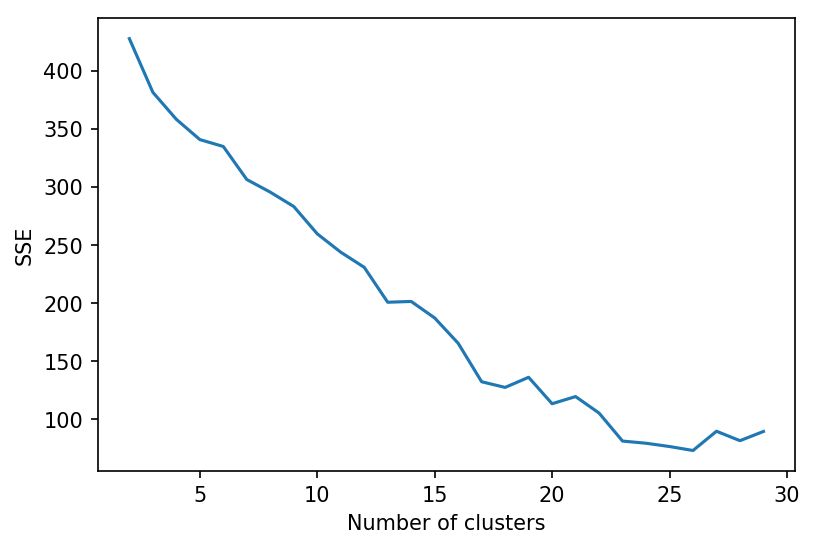

In [114]:
#Count Vectorizer

SSE = []

for k in range(2,30):
    km = MiniBatchKMeans(n_clusters = k, random_state = 42)
    km.fit(nmf_cv_data)
    labels = km.labels_
    SSE.append(km.inertia_)
    
plt.figure(dpi = 150)
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.plot(range(2,30),SSE);
#plt.ylim((0,600))

plt.savefig("cluster_plot_cv")

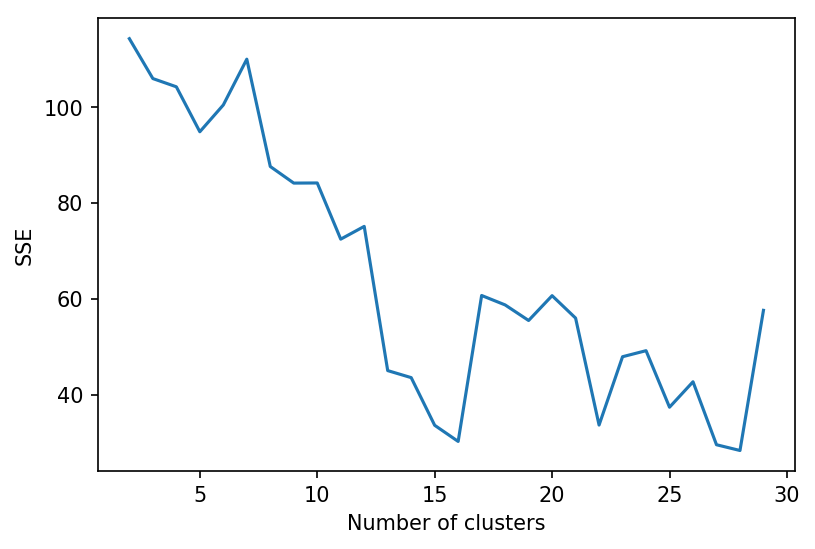

In [116]:
#TFIDF

SSE = []

for k in range(2,30):
    km = MiniBatchKMeans(n_clusters = k, random_state = 42)
    km.fit(nmf_tfidf_data)
    labels = km.labels_
    SSE.append(km.inertia_)
    
plt.figure(dpi = 150)
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.plot(range(2,30),SSE);


plt.savefig("cluster_plot_tfidf")

In [117]:
km = MiniBatchKMeans(n_clusters=13)
nmf_clusters = km.fit_predict(nmf_cv_data)

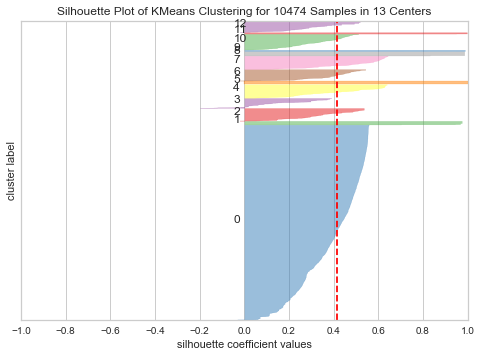

In [118]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer
visualiser = SilhouetteVisualizer(KMeans(n_clusters=13))
visualiser.fit(nmf_cv_data)
visualiser.poof()

In [119]:
model = TSNE(n_components=2, random_state = 0, verbose = 0)
low_data = model.fit_transform(nmf_cv_data)

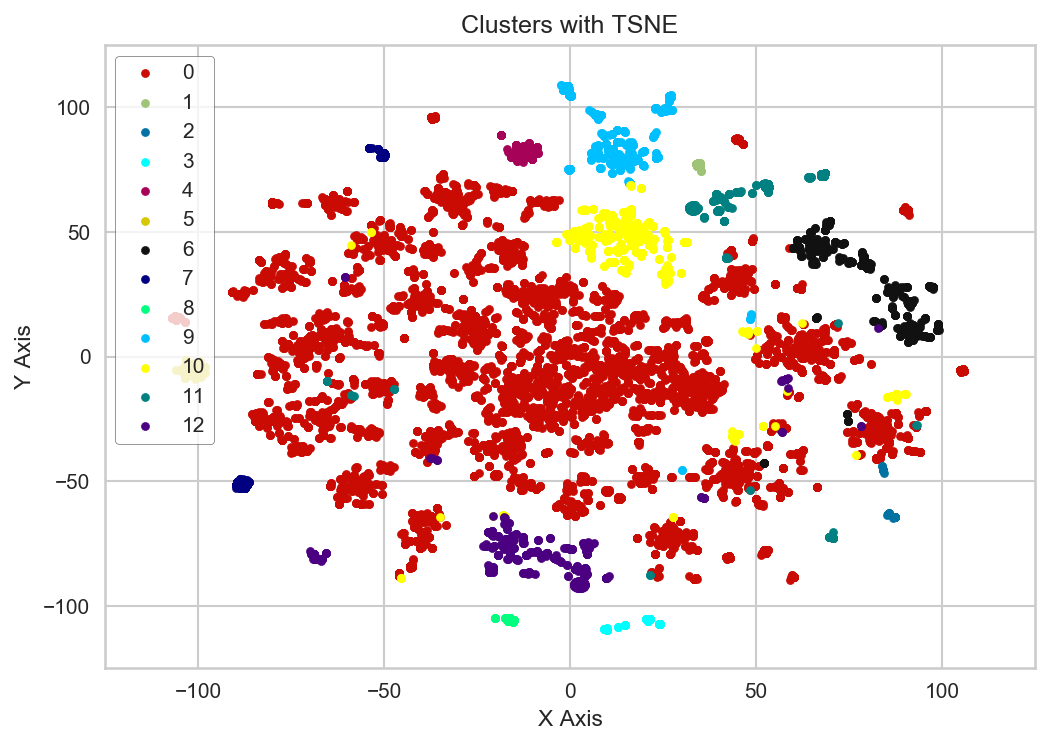

In [120]:
colors = (['r','g','b','cyan','m','y', 'k', 'navy', 'springgreen', 'deepskyblue', 'yellow', 'teal', 'indigo', 'plum'])
plt.figure(dpi = 150)

for i, c, label in zip (range(13), colors, list(range(13))):
    plt.scatter(low_data[nmf_clusters == i, 0], low_data[nmf_clusters == i, 1], c=c, label = label, s = 15, alpha = 1)

plt.legend(fontsize = 10, loc = 'upper left', frameon = True, facecolor = '#FFFFFF', edgecolor = '#333333');
plt.title("Clusters with TSNE", fontsize = 12);
plt.xlim(-125,125);
plt.ylim(-125,125);
plt.ylabel("Y Axis");
plt.xlabel("X Axis");
plt.yticks(fontsize =10);
plt.xticks(fontsize = 10);

In [121]:
km_tfidf = MiniBatchKMeans(n_clusters=13)
nmf_tfidf_clusters = km_tfidf.fit_predict(nmf_tfidf_data)

In [220]:
with open ('sustainability_clusters.pickle', 'wb') as to_write:
    pickle.dump(nmf_tfidf_clusters, to_write)

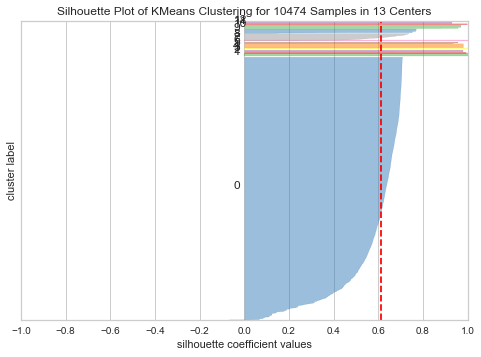

In [122]:
visualiser_tfidf = SilhouetteVisualizer(KMeans(n_clusters=13))
visualiser_tfidf.fit(nmf_tfidf_data)
visualiser_tfidf.poof()

In [124]:
model_2 = TSNE(n_components=2, random_state = 0, verbose = 0)
low_data_2 = model_2.fit_transform(nmf_tfidf_data)

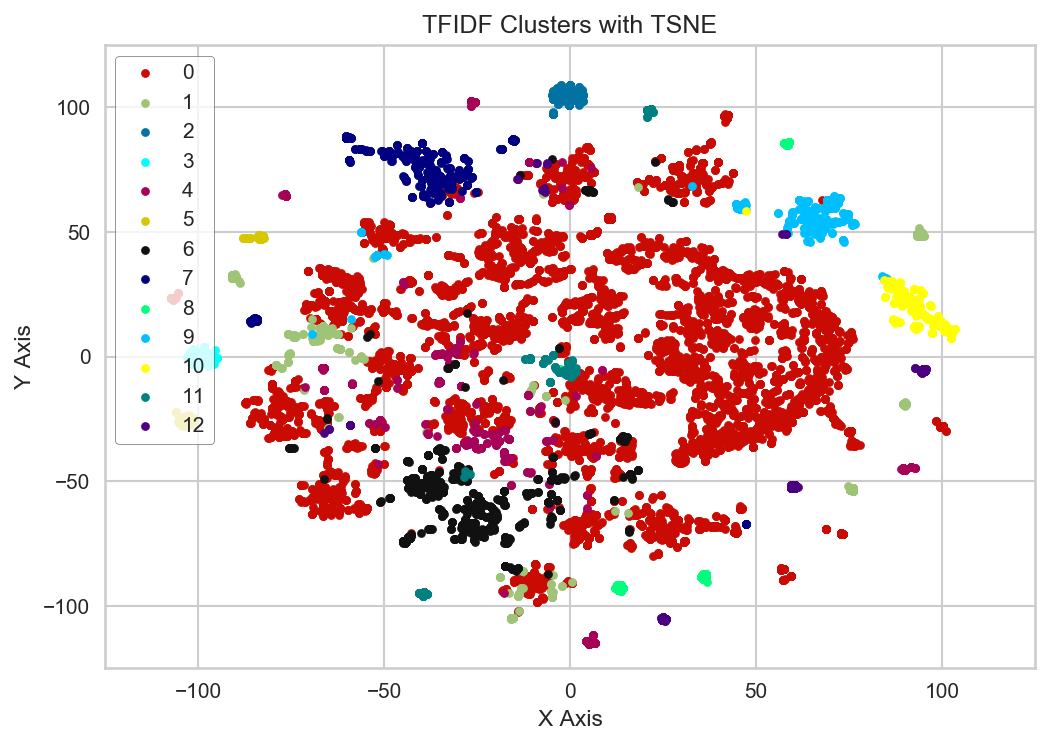

In [125]:
colors = (['r','g','b','cyan','m','y', 'k', 'navy', 'springgreen', 'deepskyblue', 'yellow', 'teal', 'indigo', 'plum'])

plt.figure(dpi = 150)

for i, c, label in zip (range(13), colors, list(range(13))):
    plt.scatter(low_data_2[nmf_tfidf_clusters == i, 0], low_data_2[nmf_tfidf_clusters == i, 1], c=c, label = label, s = 15, alpha = 1)

plt.legend(fontsize = 10, loc = 'upper left', frameon = True, facecolor = '#FFFFFF', edgecolor = '#333333');
plt.title("TFIDF Clusters with TSNE", fontsize = 12);
plt.xlim(-125,125);
plt.ylim(-125,125);
plt.ylabel("Y Axis");
plt.xlabel("X Axis");
plt.yticks(fontsize =10);
plt.xticks(fontsize = 10);

In [126]:
tsne_new = TSNE(n_components=2, random_state = 0, verbose = 0).fit_transform(nmf_tfidf_data)

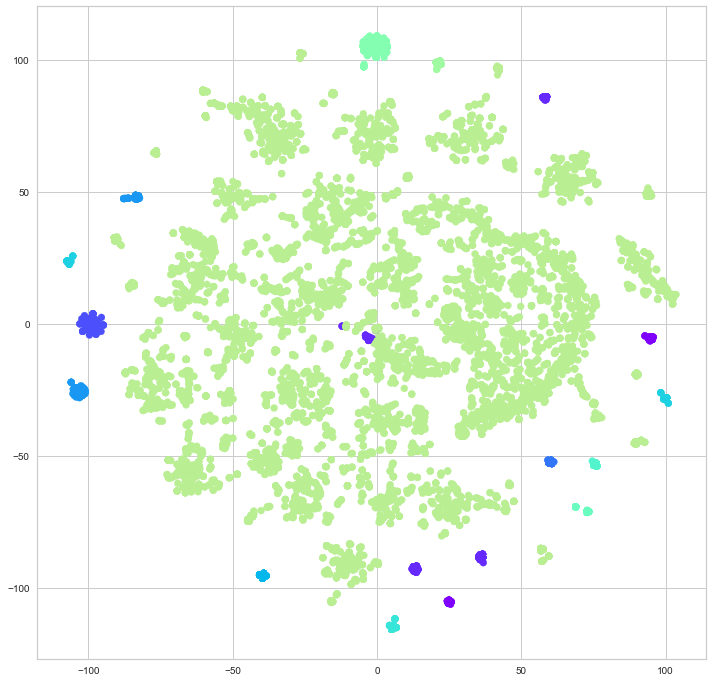

In [127]:
clus = KMeans(n_clusters=13,random_state=42)
labels = clus.fit_predict(nmf_tfidf_data)

plt.figure(figsize=(12,12))
plt.scatter(tsne_new[:,0],tsne_new[:,1],c=plt.cm.rainbow(labels*13))

In [202]:
def get_tweets(nmf_tfidf_data, nmf_tfidf_clusters, idx):
    df = pd.DataFrame(nmf_tfidf_clusters, columns = ['cluster'])
    df = df[df['cluster'] == nmf_tfidf_clusters[idx]]
    
    return(list(df.sample(10).index)) #Returns list of 10 indices with tweets in the same cluster

In [206]:
recommended_tweets = get_tweets(nmf_tfidf_data, nmf_tfidf_clusters, 30)

In [207]:
def print_tweets(idx,recommended_tweets):
    print(sustainability_collection.find()[idx]['text'])
    print('\n------\n')
    for rec_idx in recommended_tweets:
        print('\n --- Result --- \n')
        print(sustainability_collection.find()[rec_idx]['text'])

In [211]:
index_num = 1

recommended_tweets = get_tweets(nmf_tfidf_data, nmf_tfidf_clusters, index_num)
print_tweets(index_num, recommended_tweets)

Are you in Melbourne or Sydney? Join us at #SPFAustralia to learn about the latest trends in #EHS, #RiskManagement… https://t.co/BG7eWM1FCO

------


 --- Result --- 

RT @Zahrahmusa: In a big rush this morning but a ship had to pass so I had to wait for this....
Sigh...

#Netherlands 
#Sustainability http…

 --- Result --- 

Free half day business training for SMEs - How to pitch for new business &amp; how to work with the public sector. Join… https://t.co/sRrpcNkc0C

 --- Result --- 

Adding extra to your favourite #StayVacationed  resorts... #DiamondGoGreen #CromerCClub

 --- Result --- 

RT @podshipearth: New episode available! https://t.co/loA4SLGEfG  This week we talk with @PaulHShapiro, an animal welfare crusader, who bel…

 --- Result --- 

🔥🌐 RETWEET SHARE SUPPORT! 🌐🔥 @ScottHa55665467 Crisis in Nicaragua #SOSNicaragua #Sustainability @ViralExpNotify… https://t.co/CKilLTFZbw

 --- Result --- 

RT @Paula_Piccard: These unique skylights reduce #energy costs ☀️ 
#SolarEnergy #Sust

In [212]:
index_num = 6

recommended_tweets = get_tweets(nmf_tfidf_data, nmf_tfidf_clusters, index_num)
print_tweets(index_num, recommended_tweets)

RT @thefishsite: A new study suggests seafood consumers across the globe are united in thinking that the biggest threat to the oceans is po…

------


 --- Result --- 

RT @okekecc: Dear startup/small business owner; there is no all size fit template for writing business plans. It doesn't even have to be vo…

 --- Result --- 

RT @TheePlantDaddy: I have a YouTube channel that consists of plants, sustainability, diy natural products, health, and more. I’m just play…

 --- Result --- 

RT @garethhgeorge: Urban agriculture: growing food onto Manchester's buildings : https://t.co/iNtdVryHQM #UrbanAgriculture #Manchester #foo…

 --- Result --- 

We’re talking about #sustainability #goodgovernance #teamwork #employability #community with @LindaFabianiSNP thank… https://t.co/NRglq4n1V1

 --- Result --- 

#sustainability #sustainability style #CSR https://t.co/gsOXttAptV

 --- Result --- 

RT @BASCnews: We are asking shooters to collect duck and goose wings from each bird they shoot to help de

In [213]:
index_num = 4000

recommended_tweets = get_tweets(nmf_tfidf_data, nmf_tfidf_clusters, index_num)
print_tweets(index_num, recommended_tweets)

By now it is clear that there will be no outer #Sustainability without inner #Transformation. The mainstream model… https://t.co/oQvSpFNYfV

------


 --- Result --- 

“Is Eating Animals Sustainable? Wrong Question!” by @ludwig_raal 
https://t.co/OaMbIKc0aS  #sustainability

 --- Result --- 

“Procurement with Purpose” broadly means organisations using their third-party spend to support causes that go beyo… https://t.co/FoRaDAugqm

 --- Result --- 

RT @jemweb: I have driven the #Toyota #Mirai and loved it. Very fast acceleration and great handling. https://t.co/IJlHlHLZdZ

 --- Result --- 

Love this shot of @Stellathelight enjoying her soft &amp; easy slides on a beautiful day!
.
.
.
#ethicalfashion… https://t.co/gYRa3C6d0U

 --- Result --- 

RT @kashthefuturist: Doctors warn that #plasticpollution is killing the human race
#Sustainability #climatechange #plastic #waste #SDGs #Ci…

 --- Result --- 

RT @NihiloZero: The latest Possibly of Interest...! https://t.co/CxGdkKGOSc Thanks to

In [214]:
index_num = 9000

recommended_tweets = get_tweets(nmf_tfidf_data, nmf_tfidf_clusters, index_num)
print_tweets(index_num, recommended_tweets)

[Job] Energy Analyst | Company: Emory University | Location: Atlanta GA Georgia United States | #Atlanta… https://t.co/TPBF1ApSq2

------


 --- Result --- 

Focusing on #sustainability, one MIT class has come up with a highly #energyefficient design for a large community… https://t.co/GjLEqe1DIb

 --- Result --- 

#GreenHashes #GH #Green #Mining #ICO #airdrop

 --- Result --- 

On the need for #sustainable pricing for an "irreplaceable raw material"

#NaturalRubber #sustainability #tires… https://t.co/t7W8QyKuko

 --- Result --- 

RT @measurabl: #Sustainability vs. #ESG: What's the difference, and what do we need to know to be right? https://t.co/fftsRPUDad https://t.…

 --- Result --- 

RT @FashionforGood: “Sustainability is a long journey. What’s key is to deliver concrete results; after that, you have to share your diffic…

 --- Result --- 

RT @dokauk: The construction sector offers the perfect start to your professional career
https://t.co/5guvzOYyvC
#thinkconstruction #career…



In [217]:
index_num = 3500

recommended_tweets = get_tweets(nmf_tfidf_data, nmf_tfidf_clusters, index_num)
print_tweets(index_num, recommended_tweets)

RT @pokitocup: pokito -  saving space and the planet - one drink at a time! #plasticfree #coffee #pokito #Sustainability #sustainableLiving…

------


 --- Result --- 

RT @MasterGIS_Droni: #Barcellona e i #superblocks: meno macchine, più spazi pubblici e #mobilità #sostenibile
L'esperimento di PobleNou
#Su…

 --- Result --- 

Norway looking impressive for this week's @ArendalsUka - looking forward to tomorrow's Global Outlook conference: "… https://t.co/3tifzA7Ckx

 --- Result --- 

RT @BitcoinMagazine: Crypto Startup Taps Larry King in Shared Effort to Combat Climate Change 
#CryptoNews #Sustainability #BlockChainNews…

 --- Result --- 

RT @TXGreenBuilding: Free: NetZero #Energy Buildings Webinar, 7-8 pm, 8/15: https://t.co/4lADA16hfB #greenbuilding #sustainability #buildin…

 --- Result --- 

A snapshot of our hardworking Sustainability Team of volunteers after a local invasive weed pull.  Feels good to he… https://t.co/HcNEYJ1nHg

 --- Result --- 

And just as @erleellis says in t